In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import math
tf.random.set_seed(7)
# np.random.seed(7)
import datetime as dt
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error as mae
pd.options.mode.chained_assignment = None
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# tf.random.set_seed(1234)
from tensorflow.keras.layers import LSTM

In [2]:
print("Hey there")

Hey there


In [3]:
btc_input_df = pd.read_csv("FBTC-USD-mar-2017-to-06-feb-2023.csv")
# n_data= pd.read_csv("n-transactions-total.csv")
# n_data
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2168 non-null   object 
 1   Close           2168 non-null   float64
 2   High            2168 non-null   float64
 3   Low             2168 non-null   float64
 4   Open            2168 non-null   float64
 5   Volume          2168 non-null   float64
 6   n-transactions  2168 non-null   int64  
 7   MKTCP           2168 non-null   float64
 8   HRATE           2168 non-null   float64
 9   DIFF            2168 non-null   float64
 10  AVBLS           2168 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 186.4+ KB


In [4]:
# data=btc_input_df

In [5]:
# btc_input_df_datetype=btc_input_df.astype({'Date': 'datetime64'})
# data =df.astype({'Date': 'datetime64'})
dataa=btc_input_df.astype({'Date': 'datetime64'})
new_data = dataa[-60:]

new_data = new_data[['Close', 'High', 'Low', 'Open','Volume','n-transactions','MKTCP', 'HRATE','DIFF']]

test1=60
data=dataa[:-test1]

data.tail()


,Date,Close,High,Low,Open,Volume,n-transactions,MKTCP,HRATE,DIFF,AVBLS
2103,2022-12-03,16908.23633,17116.04102,16888.14063,17090.09766,1.621778e+10,250951,3.260000e+11,240623292.0,3.700000e+13,1.318575
2104,2022-12-04,17130.48633,17157.76758,16903.43945,16908.16992,1.682452e+10,219810,3.290000e+11,257154663.2,3.700000e+13,1.086378
2105,2022-12-05,16974.82617,17378.15234,16922.43164,17128.89453,2.220909e+10,274064,3.260000e+11,268175577.4,3.700000e+13,1.246358
2106,2022-12-06,17089.50391,17091.86328,16939.92188,16975.23828,1.988992e+10,262438,3.270000e+11,231289584.0,3.450000e+13,1.328944
2107,2022-12-07,16848.12695,17109.37695,16750.55859,17089.50586,1.967540e+10,272328,3.240000e+11,292794732.7,3.420000e+13,1.029506


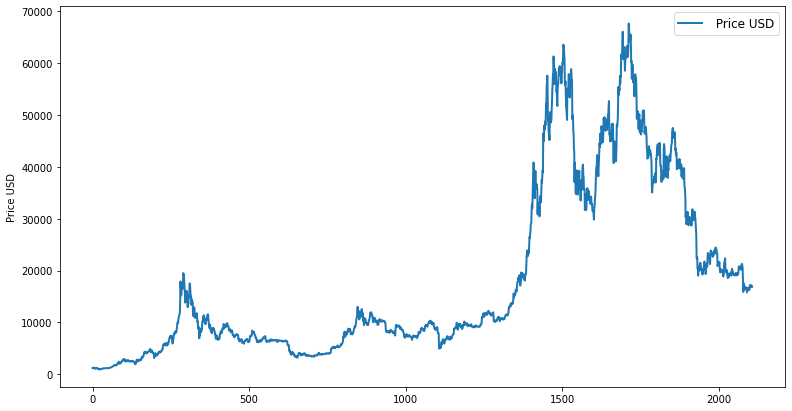

In [6]:
# btc_input_df_datetype.shape
closing_price = data['Close']
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(closing_price, label=' Price USD', linewidth=2)
# ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=10)
ax.set_title('', fontsize=12)
ax.legend(loc='best', fontsize=12)

In [7]:
n_forecast = 1
# data=dataa['Close'].values.reshape(-1,1)
# data = data[['Close','Volume','n-transactions','MKTCP', 'HRATE','DIFF','AVBLS']]
data = data[['Close', 'High', 'Low', 'Open','Volume','n-transactions','MKTCP', 'HRATE','DIFF']]
# data = data[['Close', 'High', 'Low', 'Open','Volume','n-transactions','MKTCP', 'HRATE']]
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

# X_train = X_scaler.fit_transform(data)

# train_data = X_train[:len(X_train)-31]
# test_data = X_train[len(X_train)-31:]
# test_data = X_scaler.transform(X_test)

X_train = data[:len(data)-90]
X_test = data[len(data)-90:]

train_data = X_scaler.fit_transform(X_train)


test_data = X_scaler.transform(X_test)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
# print(test_data)
# test_data = test_data1[:-32]
# X_data = X_scaler.transform(data[['Close']])

# scaler = MinMaxScaler(feature_range=(0, 1))

# df_test.shape
# print(test_data)

In [8]:
def dataset_generator_lstm(dataset, look_back=30):
    
    x_test, y_test = [], []

    for i in range(look_back, len(dataset)- n_forecast+1):
        
        x_test.append(dataset[i -look_back: i,0:dataset.shape[1]])
        y_test.append(dataset[i:i+n_forecast,0])
           
    return np.array(x_test), np.array(y_test)
# x_test = np.array(x_test)
# y_test = np.array(y_test)
trainX, trainY = dataset_generator_lstm(train_data)

testX, testY = dataset_generator_lstm(test_data)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

# print(testY)
# x_test.shape


trainX:  (1988, 30, 9)
trainY:  (1988, 1)
testX:  (60, 30, 9)
testY (60, 1)


In [9]:
# trainX = np.reshape(trainX, (trainX.shape[0], trai/

print("Shape of trainX: ", trainX.shape)
# print("Shape of testX: ", testX.shape)
# testX.shape[1]

Shape of trainX:  (1988, 30, 9)


In [10]:
# xn
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=trainX.shape[1:]))
# model.add(LSTM(units=50,return_sequences=True,input_shape = input_shape=trainX.shape[1:]))
model.add(LSTM(units=50))
model.add(Dense(units=n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')

# scores = model.evaluate(testX, testY, verbose=0)
# # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# cvscores.append(scores[1] * 100)
 
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [11]:
epochs = 50
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

history = model.fit(trainX, trainY, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(testX, testY)
                   )
# score=model.evaluate(testX,testY,verbose =0)
# print(score[0])
# print(score[1])
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

Epoch 1/50
63/63 [==============================] - 9s 53ms/step - loss: 0.0143 - val_loss: 0.0018
Epoch 2/50
63/63 [==============================] - 2s 31ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/50
63/63 [==============================] - 2s 30ms/step - loss: 0.0012 - val_loss: 6.5581e-04
Epoch 4/50
63/63 [==============================] - 2s 30ms/step - loss: 0.0011 - val_loss: 8.8617e-04
Epoch 5/50
63/63 [==============================] - 2s 30ms/step - loss: 9.8812e-04 - val_loss: 3.7564e-04
Epoch 6/50
63/63 [==============================] - 2s 30ms/step - loss: 8.9177e-04 - val_loss: 3.2321e-04
Epoch 7/50
63/63 [==============================] - 2s 33ms/step - loss: 8.2507e-04 - val_loss: 9.3260e-04
Epoch 8/50
63/63 [==============================] - 2s 30ms/step - loss: 7.2562e-04 - val_loss: 3.0447e-04
Epoch 9/50
63/63 [==============================] - 2s 30ms/step - loss: 7.6144e-04 - val_loss: 4.7587e-04
Epoch 10/50
63/63 [==============================] - 2s 30ms/

2/2 [==============================] - 1s 14ms/step


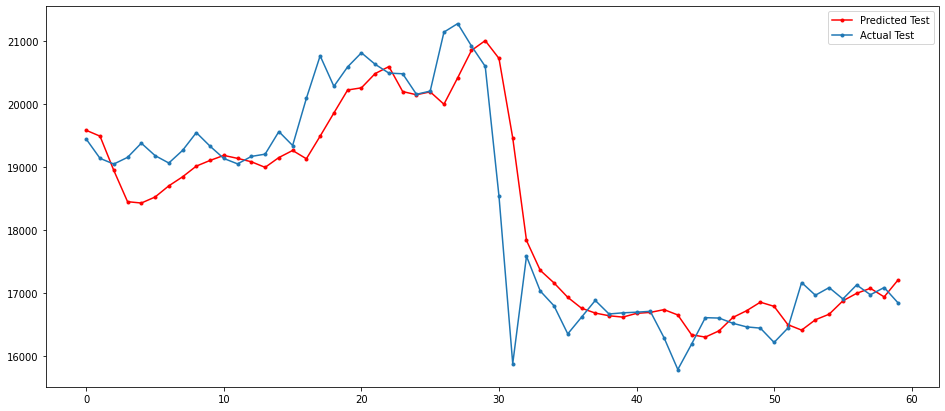

Mean Absolute Error (MAE): 424.5
Mean Absolute Percentage Error (MAPE): 2.34 %
Test RMSE: 701.159


In [12]:
from sklearn.metrics import mean_absolute_percentage_error

yhat = model.predict(testX)
# print(yhat)
y_pred = scaler_pred.inverse_transform(yhat)
# print(y_pred)
# print(testY)
y_test_unscaled = scaler_pred.inverse_transform(testY.reshape(-1, 1))
# print(y_test_unscaled)


plt.figure(figsize=(16,7))

plt.plot(y_pred, 'r', marker='.', label='Predicted Test')

plt.plot(y_test_unscaled, marker='.', label='Actual Test')

plt.legend()
plt.show()


MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100

print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
print('Test RMSE: %.3f' % rmse)
# print(mean_absolute_percentage_error(y_test_unscaled, y_pred))

In [13]:
df_temp = data[-30:]

last_N_days = df_temp[-30:].values

Actual_price = 17233.474
last_day_price= 16848.126
# print(last_N_days)

last_N_days_scaled = X_scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

print("The last day price was :",last_day_price)
print(' ')
print("The predicted price for the next day is:",pred_price_unscaled)
print("The actual price is:",Actual_price)


# rmse = np.sqrt(mean_squared_error(Actual_price, pred_price_unscaled))
# print('Test RMSE: %.3f' % rmse)


1/1 [==============================] - 0s 25ms/step
The last day price was : 16848.126
 
The predicted price for the next day is: [[17165.652]]
The actual price is: 17233.474


In [14]:
# last_New_data = new_data[-30:].values
# # Actual_price = 22901.96
# # print(last_N_da)

# last_New_data_scaled = X_scaler.transform(last_New_data)

# # Create an empty list and Append past N days
# Xtest_N = []
# Xtest_N.append(last_New_data_scaled)

# # Convert the X_test data set to a numpy array and reshape the data
# pred_scaled = model.predict(np.array(Xtest_N))
# pred_unscaled = scaler_pred.inverse_transform(pred_scaled.reshape(-1, 1))
# print(' ')
# print("predicted price for the next day is :", pred_unscaled)

In [15]:
# [[16899.016]]
# df_temp1 = dataa[-60:-30]

# df_temp1= df_temp1[['Close', 'High', 'Low', 'Open','Volume','n-transactions','MKTCP', 'HRATE','DIFF']]
# last_N_day = df_temp1[-30:].values
# # Actual_price = 22901.96
# # print(last_N_day)

# last_N_days_scale = X_scaler.transform(last_N_day)

# # Create an empty list and Append past N days
# Xtest_new = []
# Xtest_new.append(last_N_days_scale)

# # Convert the X_test data set to a numpy array and reshape the data
# pred_price_scale = model.predict(np.array(Xtest_new))
# pred_price_unscale = scaler_pred.inverse_transform(pred_price_scale.reshape(-1, 1))
# print(pred_price_unscale)